# Step 1: Data Preparation and Preprocessing

This notebook performs batch preprocessing of RAVDESS audio files for emotion recognition. The main steps include:

**Audio Loading:** Load RAVDESS audio files corresponding to the five target emotions: Neutral, Angry, Happy, Sad, and Fearful. If the dataset includes additional emotions (e.g., calm, surprise, disgust), filter them out so only the five target categories remain. Ensure class labels are correctly assigned for these five categories.

**Resampling:** Convert all audio clips to a consistent sampling rate of 16,000 Hz (16 kHz). This down-sampling is a common practice to reduce data size and match typical speech processing settings ([ieeecai.org](https://ieeecai.org)). RAVDESS originals are high-quality 44.1–48 kHz ([arxiv.org](https://arxiv.org)), but 16 kHz is sufficient to capture vocal frequency range while easing computation ([ieeecai.org](https://ieeecai.org)).

**Duration and Silence Trimming:** Optionally, trim leading/trailing silences and ensure each clip has a reasonable length. Most RAVDESS clips are a few seconds long; maintaining the full utterance is usually fine. You may apply a voice activity detection or simple energy threshold to remove long silences.

**Normalization:** Normalize audio amplitude (for example, to -3 dB FS) or use per-clip volume normalization. This ensures that energy features reflect relative dynamics rather than microphone gain differences.


## Install dependencies (run if needed)

In [1]:

# %pip install librosa soundfile numpy pandas tqdm matplotlib
# In Colab you may also need system ffmpeg:
# !apt-get -y install ffmpeg


## Config

In [2]:

from pathlib import Path

# Root containing Actor_01, Actor_02, ... (adjust if nested deeper)
RAW_DIR       = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data/raw")
# If your data is under .../ravdess/Audio_Speech_Actors_01-24/Actor_01, set:
# RAW_DIR = Path("data/raw/ravdess/Audio_Speech_Actors_01-24")

PROCESSED_DIR = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data/processed")
TARGET_SR     = 16000

# Preprocessing toggles
DO_TRIM_SILENCE   = True
TRIM_TOP_DB       = 20
TRIM_FRAME_LENGTH = 2048
TRIM_HOP_LENGTH   = 512

DO_NORMALIZE = True
PEAK_DBFS    = -3.0

# Preserve Actor_XX subfolders in output
PRESERVE_ACTOR_SUBDIRS = True

# Extensions to scan (include both cases)
AUDIO_EXTS = (".wav", ".WAV")

print("RAW_DIR exists?:", RAW_DIR.exists(), "| is_dir?:", RAW_DIR.is_dir())
print("RAW_DIR resolved:", RAW_DIR.resolve())
print("PROCESSED_DIR   :", PROCESSED_DIR.resolve())


RAW_DIR exists?: True | is_dir?: True
RAW_DIR resolved: /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw
PROCESSED_DIR   : /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed


## Imports & helpers

In [3]:

import re
from typing import Dict, List
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa, soundfile as sf
import matplotlib.pyplot as plt 
from scipy.signal import resample_poly 
import math                             

# Emotions to keep (RAVDESS code -> label)
EMOTION_CODE_TO_NAME: Dict[str, str] = {
    "01": "neutral",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
}

# RAVDESS filename pattern: MM-CC-EE-SS-RR-AA (EE is 3rd token)
two_digit = r"(\d{2})"
ravdess_pattern = re.compile(
    rf"^{two_digit}-{two_digit}-{two_digit}-{two_digit}-{two_digit}-{two_digit}-{two_digit}"
)

def parse_emotion_code(p: Path) -> str:
    m = ravdess_pattern.match(p.name)
    return m.group(3) if m else ""

def dbfs_to_linear(db: float) -> float:
    return 10.0 ** (db / 20.0)

def peak_normalize(y: np.ndarray, target_dbfs: float = -3.0, eps: float = 1e-9) -> np.ndarray:
    peak = float(np.max(np.abs(y)) + eps)
    target_peak = dbfs_to_linear(target_dbfs)
    y = y * (target_peak / peak)
    return np.clip(y, -1.0, 1.0)

def trim_silence(y: np.ndarray, sr: int) -> np.ndarray:
    yt, _ = librosa.effects.trim(
        y, top_db=TRIM_TOP_DB, frame_length=TRIM_FRAME_LENGTH, hop_length=TRIM_HOP_LENGTH
    )
    return yt

def resample_if_needed(y, sr, target_sr):
    if sr == target_sr:
        return y
    g = math.gcd(sr, target_sr)  # e.g., gcd(48000,16000)=16000
    up = target_sr // g          # 1
    down = sr // g               # 3
    return resample_poly(y, up, down)  # high-quality polyphase resample



## Discover `Actor_*` folders (any depth)

In [4]:

# Find all directories whose name starts with 'Actor_' (case-insensitive)
actor_dirs = sorted({p for p in RAW_DIR.rglob("*") if p.is_dir() and p.name.lower().startswith("actor_")})
print(f"Found {len(actor_dirs)} actor folders under {RAW_DIR}")
for p in actor_dirs[:10]:
    print("•", p)
if not actor_dirs:
    print("No Actor_* folders detected. If your dataset has 'Audio_Speech_Actors_01-24', set RAW_DIR to that folder.")


Found 24 actor folders under /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_02
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_03
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_04
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_05
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_06
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_07
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_08
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_09
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_10


## Dry run: show a few WAVs per first actor (no processing)

In [5]:

sample_listed = 0
if actor_dirs:
    first_actor = actor_dirs[0]
    print("First actor dir:", first_actor)
    demo = []
    for ext in AUDIO_EXTS:
        demo.extend(first_actor.rglob(f"*{ext}"))
    demo = sorted(demo)[:10]
    print(f"Sample WAVs in {first_actor.name}: {len(demo)}")
    for p in demo:
        print("•", p)
else:
    print("No actors to show. Adjust RAW_DIR and rerun discovery.")


First actor dir: /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01
Sample WAVs in Actor_01: 10
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-02-01-01-02-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-02-01-02-01-01.wav
• /Users/nishchalpokhrel/Documents/project/thesis_code/data/raw/RAVDESS/Actor_01/03-01-02-01-02-02-01.wav
• /Users/nishchalpokhrel/Doc

## Process all actors and save

In [6]:

rows = []
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

total_seen = 0
for actor in actor_dirs:
    wavs = []
    for ext in AUDIO_EXTS:
        wavs.extend(actor.rglob(f"*{ext}"))
    wavs = sorted(wavs)
    print(f"{actor.name}: {len(wavs)} files")
    total_seen += len(wavs)

    for fpath in tqdm(wavs, desc=f"{actor.name}", leave=False):
        emo_code = parse_emotion_code(fpath)
        if emo_code not in EMOTION_CODE_TO_NAME:
            continue
        emotion = EMOTION_CODE_TO_NAME[emo_code]

        try:
            y, sr = sf.read(str(fpath), always_2d=False)
            if y.ndim > 1:
                y = y.mean(axis=1)
            y = y.astype(np.float32, copy=False)

            dur_before = len(y) / sr
            peak_before = float(np.max(np.abs(y)))

            if DO_TRIM_SILENCE:
                y = trim_silence(y, sr)

            y = resample_if_needed(y, sr, TARGET_SR)

            if DO_NORMALIZE:
                y = peak_normalize(y, PEAK_DBFS)

            dur_after = len(y) / TARGET_SR
            peak_after = float(np.max(np.abs(y)))

            # Output folder
            out_dir = PROCESSED_DIR / emotion / actor.name if PRESERVE_ACTOR_SUBDIRS else PROCESSED_DIR / emotion
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / fpath.name

            sf.write(str(out_path), y, TARGET_SR, subtype="PCM_16")

            rows.append({
                "actor": actor.name,
                "in_path": str(fpath),
                "out_path": str(out_path),
                "emotion": emotion,
                "emotion_code": emo_code,
                "orig_sr": sr,
                "target_sr": TARGET_SR,
                "dur_before_sec": dur_before,
                "dur_after_sec": dur_after,
                "peak_before": peak_before,
                "peak_after": peak_after,
                "trimmed": DO_TRIM_SILENCE,
                "normalized_to_dbfs": PEAK_DBFS if DO_NORMALIZE else None,
                "error": None,
            })

        except Exception as e:
            rows.append({
                "actor": actor.name,
                "in_path": str(fpath),
                "out_path": None,
                "emotion": None,
                "emotion_code": None,
                "orig_sr": None,
                "target_sr": TARGET_SR,
                "dur_before_sec": None,
                "dur_after_sec": None,
                "peak_before": None,
                "peak_after": None,
                "trimmed": DO_TRIM_SILENCE,
                "normalized_to_dbfs": PEAK_DBFS if DO_NORMALIZE else None,
                "error": str(e),
            })

print("Total WAV files seen across actors:", total_seen)


Actor_01: 60 files


Actor_02: 60 files


Actor_03: 60 files


Actor_04: 60 files


Actor_05: 60 files


Actor_06: 60 files


Actor_07: 60 files


Actor_08: 60 files


Actor_09: 60 files


Actor_10: 60 files


Actor_11: 60 files


Actor_12: 60 files


Actor_13: 60 files


Actor_14: 60 files


Actor_15: 60 files


Actor_16: 60 files


Actor_17: 60 files


Actor_18: 60 files


Actor_19: 60 files


Actor_20: 60 files


Actor_21: 60 files


Actor_22: 60 files


Actor_23: 60 files


Actor_24: 60 files


Total WAV files seen across actors: 1440


## Save metadata & quick stats

In [ ]:

import pandas as pd

meta = pd.DataFrame(rows)
meta_path = PROCESSED_DIR / "metadata.csv"
meta.to_csv(meta_path, index=False)
print(f"Saved metadata → {meta_path.resolve()}")

kept = meta[meta['out_path'].notna() & meta['emotion'].notna()]
print(f"Processed {len(kept)} files into {PROCESSED_DIR}")
if len(kept):
    print("Emotions:", sorted(kept['emotion'].unique()))
    print(kept.groupby(['actor','emotion']).size().reset_index(name='count').head())
else:
    print("No files processed. Verify RAW_DIR and file naming.")


Saved metadata → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/metadata.csv
Processed 864 files into /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed
Emotions: ['angry', 'fearful', 'happy', 'neutral', 'sad']
      actor  emotion  count
0  Actor_01    angry      8
1  Actor_01  fearful      8
2  Actor_01    happy      8
3  Actor_01  neutral      4
4  Actor_01      sad      8


## Quick plots

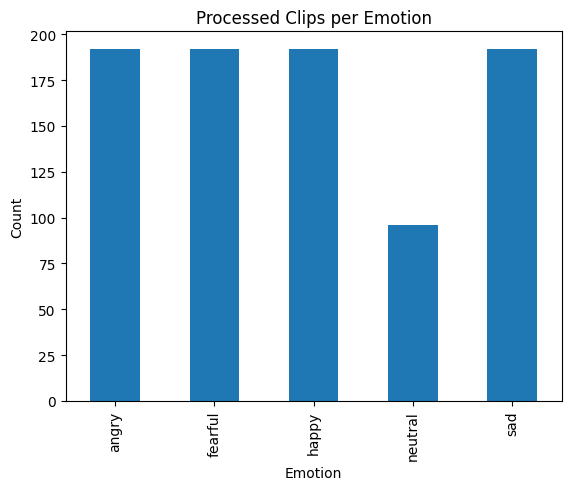

In [8]:

if len(kept):
    import matplotlib.pyplot as plt
    plt.figure(); kept['emotion'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Emotion'); plt.ylabel('Count'); plt.title('Processed Clips per Emotion'); plt.show()
